In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras import layers
import cv2
import csv

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
#Mount google drive to colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
images_path = "./gdrive/MyDrive/data/Unzipped images/images/"
annotations_path = "./gdrive/MyDrive/data/annotations/"
model_path = "./gdrive/MyDrive/models/effnetB2_mdl_wts.hdf5"
#model_path = "./gdrive/MyDrive/models/effnetB2_mdl_wts_mark2.hdf5"
IMG_SIZE = 260 ##260 for EfficientNetB2

In [ ]:
def build_model():
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  ##model = EfficientNetB0(include_top=False, input_tensor=inputs, weights=None)
  model = EfficientNetB2(include_top=False, input_tensor=inputs, weights=None)
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)
  top_dropout_rate = 0.2 ##U jednom radu su napisali da nisu korisltili dropout, mozda izbaciti?
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
  return model

In [ ]:
def visualize_one_sample(image, annotations):
    color = 'red'
    plt.figure(figsize=(6, 4))
    image = np.array(image)
    plt.imshow(image, aspect='equal')
    current_axis = plt.gca()
    
    if len(annotations) == 0:
        print("There is no defects in this image...")
        
    for box in annotations:
        xmin = box[0] 
        ymin = box[1] 
        xmax = box[2] 
        ymax = box[3]
        
        w = xmax - xmin
        h = ymax - ymin
        current_axis.add_patch(plt.Rectangle((xmin, ymin), w, h, color=color, fill=False, linewidth=2))

    plt.show()

In [ ]:
def get_data(file_name):
  annotations = open(annotations_path + file_name)
  images = []
  labels = []

  brojac = 0 ##Maknuti kada treba ucitati sve podatke
  for row in csv.reader(annotations):
    if row[5] == "1":
      if brojac == 10: ##Maknuti kada treba ucitati sve podatke
        break          ##Maknuti kada treba ucitati sve podatke
      brojac += 1
      try:
        image = cv2.imread(images_path + row[0]) 
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        images.append(image)
        #Convert to one hot array
        if row[5]=="0":
          labels.append([1, 0, 0, 0, 0, 0]) 
        else:
          labels.append([0, 1, int(row[1]), int(row[2]), int(row[3]), int(row[4])])
      except:
        print(images_path + row[0])
  annotations.close()
  # print(labels[0][2:])
  # for i in range(len(images)):
  #   visualize_one_sample(images[i], [labels[i][2:]])
  # print(labels[:10])
  return np.array(images), labels

In [ ]:
def create_heatmap(image, model, last_layer_name, pred_index=None):
  img_array = keras.preprocessing.image.img_to_array(image)
  img_array = np.expand_dims(img_array, axis=0)
  grad_model = tf.keras.models.Model([model.inputs], 
                                     [model.get_layer(last_layer_name).output, model.output])
  with tf.GradientTape() as tape:
        last_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
  grads = tape.gradient(class_channel, last_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
  last_layer_output = last_layer_output[0]
  heatmap = tf.matmul(last_layer_output, pooled_grads[..., tf.newaxis])
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

In [ ]:
images, labels = get_data("test_annotations.csv")

In [ ]:
model = build_model()
model.load_weights(model_path)
##model.summary()


last_layer_name = "block7a_expand_conv" ##top_conv   block7a_expand_conv    block6e_project_conv
model.layers[-1].activation = None
##preds = model.predict(img_array)
##print(preds)

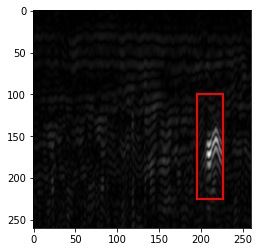

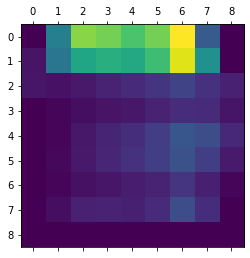

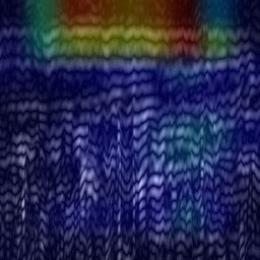

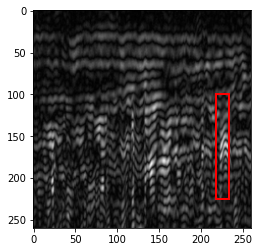

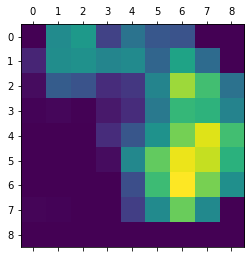

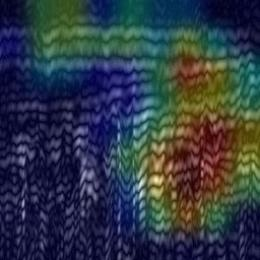

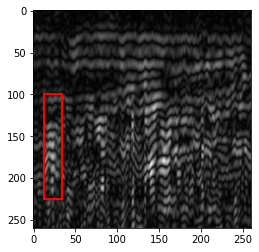

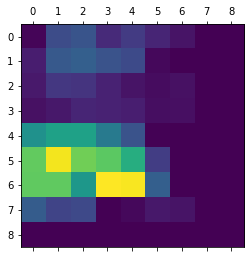

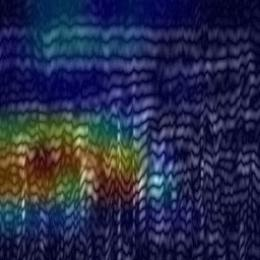

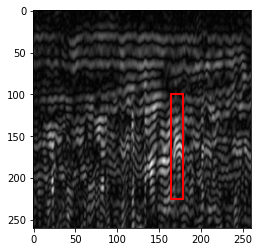

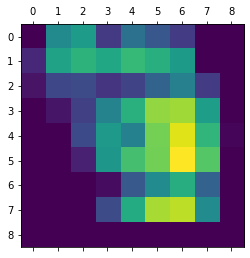

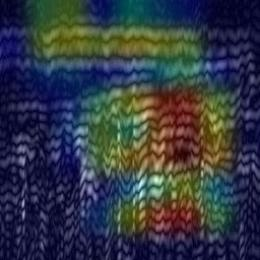

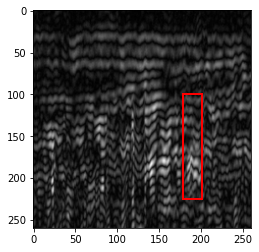

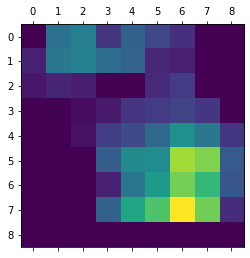

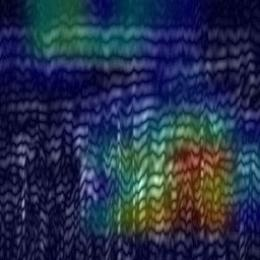

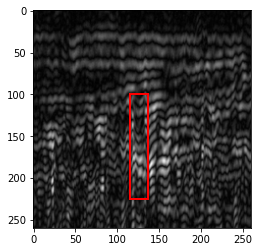

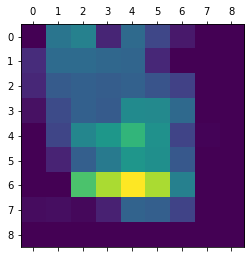

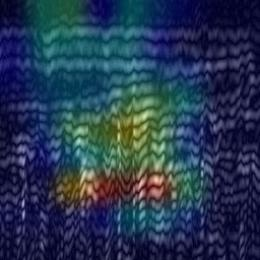

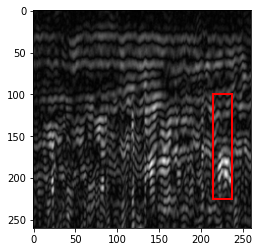

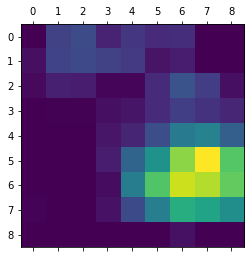

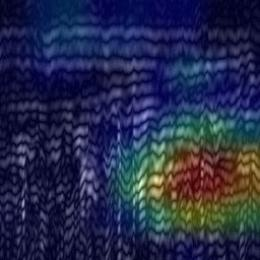

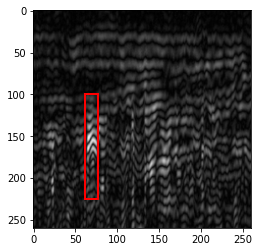

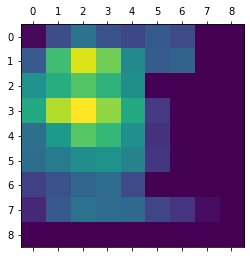

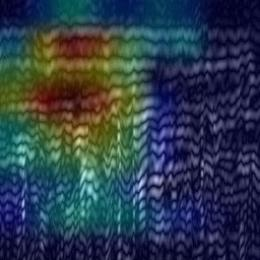

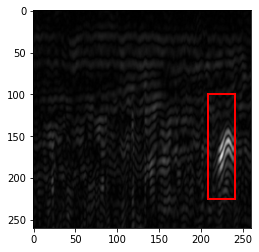

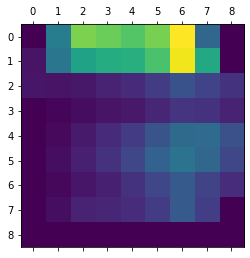

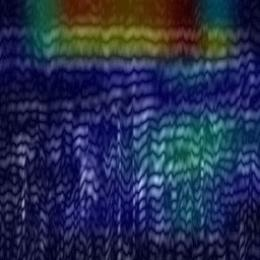

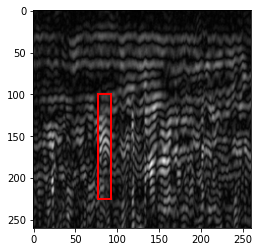

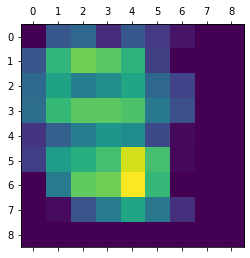

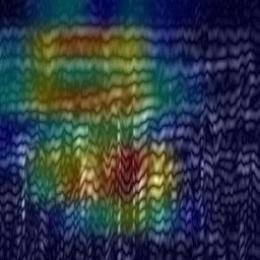

In [ ]:
img_index = 0
for img_array in images:
  heatmap = create_heatmap(img_array, model, last_layer_name)
  visualize_one_sample(images[img_index], [labels[img_index][2:]])
  plt.matshow(heatmap)
  plt.show()
  cam_path = "cam.jpg"
  alpha = 0.4
  heatmap = np.uint8(255 * heatmap)

  jet = cm.get_cmap("jet")

  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + image
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


  superimposed_img.save(cam_path)
  display(Image(cam_path))
  img_index += 1